In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import pywt
import heartpy as hp
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, resample
from scipy import signal
from data_subplot import data_subplot

from detect_body_movements import detect_patterns
from band_pass_filtering import band_pass_filtering
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
import math
from remove_nonLinear_trend import remove_nonLinear_trend
from compute_vitals import vitals

%matplotlib inline

In [2]:


# SYNC
def build_bcg_df(bcg_values, initial_timestamp, fs):
    """
    Constructs a BCG DataFrame from raw values, initial timestamp, and sampling rate.
    
    Args:
        bcg_values: List of BCG signal values (e.g., [-86, -90, -91, -86])
        initial_timestamp: Timestamp of first sample (epoch ms or datetime string)
        fs: Sampling frequency in Hz
        
    Returns:
        pd.DataFrame with columns: ['Timestamp', 'BCG', 'Time']
    """
    # Convert timestamp to datetime if it's a string
    if isinstance(initial_timestamp, str):
        initial_timestamp = pd.to_datetime(initial_timestamp)
    elif isinstance(initial_timestamp, (int, float)):
        initial_timestamp = pd.to_datetime(initial_timestamp, unit='ms')
    
    # Calculate time intervals
    period = 1 / fs
    timestamps = [initial_timestamp + pd.Timedelta(seconds=i*period) 
                 for i in range(len(bcg_values))]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'BCG': bcg_values
    })
    
    # Add human-readable time
    df['Time'] = df['Timestamp'].dt.strftime('%H:%M:%S.%f')
    
    return df




def synchronize_bcg_and_hr(df_bcg_raw, df_hr_raw):
    """
    Builds and synchronizes BCG and HR DataFrames starting from the first common time.
    
    Args:
        df_bcg_raw: Raw BCG DataFrame from CSV. Must contain 'BCG', 'Timestamp', and 'fs' columns.
        df_hr_raw: Raw HR DataFrame from CSV. Must contain 'Timestamp' column in datetime-compatible format.
    
    Returns:
        bcg_aligned, hr_aligned: Time-synchronized DataFrames
    """
        # Parse BCG values and metadata
    bcg_values = df_bcg_raw['BCG'].tolist()
    initial_timestamp = pd.to_datetime(df_bcg_raw.loc[0, 'Timestamp'], unit='ms')
    fs = float(df_bcg_raw.loc[0, 'fs'])

    # Build BCG DataFrame
    df_bcg = build_bcg_df(bcg_values, initial_timestamp, fs)

    # Parse HR timestamps
    df_hr_raw['Timestamp'] = pd.to_datetime(df_hr_raw['Timestamp'])

    # Find common time range
    start_time = max(df_bcg['Timestamp'].min(), df_hr_raw['Timestamp'].min())
    end_time = min(df_bcg['Timestamp'].max(), df_hr_raw['Timestamp'].max())

    # Trim both DataFrames to common range
    bcg_aligned = df_bcg[(df_bcg['Timestamp'] >= start_time) & (df_bcg['Timestamp'] <= end_time)].copy()
    hr_aligned = df_hr_raw[(df_hr_raw['Timestamp'] >= start_time) & (df_hr_raw['Timestamp'] <= end_time)].copy()

    # Reset index
    bcg_aligned.reset_index(drop=True, inplace=True)
    hr_aligned.reset_index(drop=True, inplace=True)

    return bcg_aligned, hr_aligned






In [18]:

#read csv files
df_bcg= pd.read_csv('/home/bahey/bio_data/dataset/data/03/BCG/03_20231105_BCG.csv')        #### n4 &
df_heart=pd.read_csv("/home/bahey/bio_data/dataset/data/03/Reference/RR/03_20231105_RR.csv")   #### 1 second one

# step 1 :Synchronize BCG and HR DataFrames from the first common time
bcg_sync, hr_sync = synchronize_bcg_and_hr(df_bcg, df_heart)

print("Time synchronized BCG DataFrame:")
print(bcg_sync.head())
print("\nTime synchronized Heart Rate DataFrame:")
print(hr_sync.head())


Time synchronized BCG DataFrame:
                      Timestamp  BCG             Time
0 2023-11-05 00:03:48.005714285  -60  00:03:48.005714
1 2023-11-05 00:03:48.012857142  -79  00:03:48.012857
2 2023-11-05 00:03:48.019999999  -77  00:03:48.019999
3 2023-11-05 00:03:48.027142857  -80  00:03:48.027142
4 2023-11-05 00:03:48.034285714  -58  00:03:48.034285

Time synchronized Heart Rate DataFrame:
            Timestamp  Heart Rate  RR Interval in seconds
0 2023-11-05 00:03:48          84                   0.813
1 2023-11-05 00:03:49          83                   0.876
2 2023-11-05 00:03:50          81                   0.745
3 2023-11-05 00:03:50          81                   0.706
4 2023-11-05 00:03:51          81                   0.722


In [19]:
hr_sync['Timestamp'] = pd.to_datetime(hr_sync['Timestamp'])

# Set Timestamp as the index
hr_sync.set_index('Timestamp', inplace=True)




In [20]:
# resample bcg to 50 hz 
bcg_sync.set_index('Timestamp', inplace=True)

# Original sampling rate (140 Hz)
fs_original = 140  
# Target sampling rate (50 Hz)
fs_target = 50  

# Calculate resampling factor
resample_factor = fs_target / fs_original

# Number of samples in resampled signal
num_samples = int(len(bcg_sync) * resample_factor)

# Resample the BCG signal using Fourier method (preserves timing information)
resampled_bcg = signal.resample(bcg_sync['BCG'], num_samples)

# Create new timestamps for the resampled data
start_time = bcg_sync.index[0]
end_time = bcg_sync.index[-1]
new_timestamps = pd.date_range(start=start_time, end=end_time, periods=num_samples)

# Create new DataFrame with resampled data
resampled_df = pd.DataFrame({
    'BCG': resampled_bcg,
    'Time': new_timestamps.time
}, index=new_timestamps)

# Reset index if you want Timestamp as a column again
resampled_df.reset_index(inplace=True)
resampled_df.rename(columns={'index': 'Timestamp'}, inplace=True)

print(resampled_df.head())

                      Timestamp         BCG             Time
0 2023-11-05 00:03:48.005714285 -123.144952  00:03:48.005714
1 2023-11-05 00:03:48.025714400  -47.512363  00:03:48.025714
2 2023-11-05 00:03:48.045714516  -75.158862  00:03:48.045714
3 2023-11-05 00:03:48.065714632 -206.820384  00:03:48.065714
4 2023-11-05 00:03:48.085714748  -22.344240  00:03:48.085714


In [21]:
total =len(resampled_df)/500
total = int(total)
print(total)

517


/tmp/ipykernel_18368/451351055.py:3: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds


Data stream length: 258632
Bad windows: [  4  59  60  68  69  81  82 111 114 130 150 151 184 212 213 214 215 216
 217 218 223 232 240 242 243 250 251 252 253 256 265 266 267 268 270 284
 285 286 287 289 290 300 305 314 315 326 340]


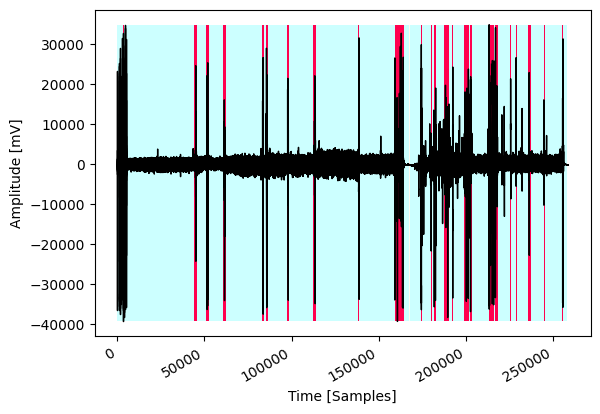

In [22]:
bcg = resampled_df
start_point, end_point, window_shift, fs = 0, 750, 750, 50
bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds
utc_time = bcg['epoch']
data_stream = bcg['BCG']
print("Data stream length:", len(data_stream))
data_stream, utc_time, bad_windows  = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
print("Bad windows:", bad_windows)

In [23]:
print(data_stream)
print(utc_time)

1         -47.512363
2         -75.158862
3        -206.820384
5        -100.563354
6        -392.094859
             ...    
258627   -203.479996
258628   -206.553659
258629   -204.298447
258630   -205.966303
258631   -208.169397
Name: BCG, Length: 258584, dtype: float64
1         1699142628025
2         1699142628045
3         1699142628065
5         1699142628105
6         1699142628125
              ...      
258627    1699147800575
258628    1699147800595
258629    1699147800615
258630    1699147800635
258631    1699147800655
Name: epoch, Length: 258584, dtype: int64


Wavelet Cycle Length: 258584


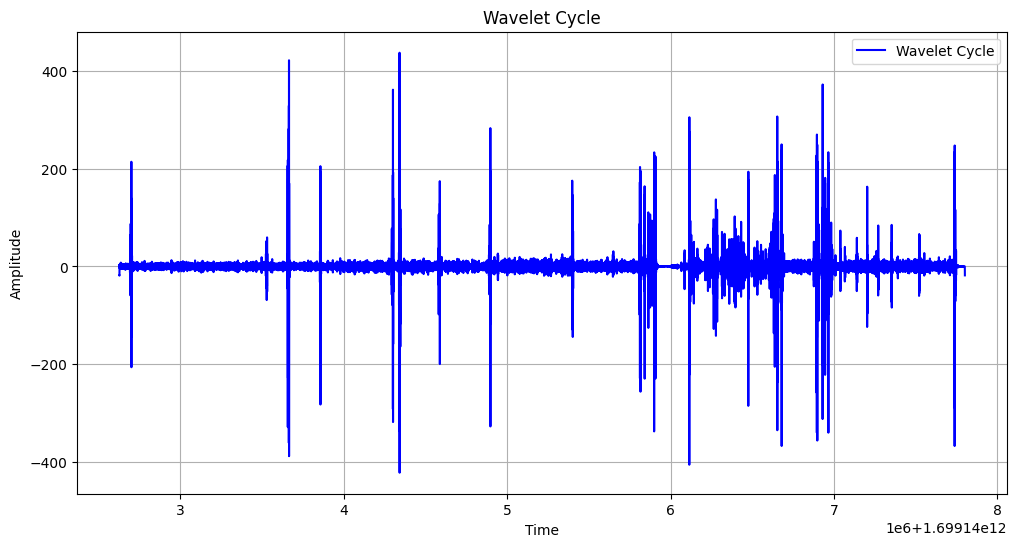

In [24]:
movement = band_pass_filtering(data_stream, fs, "bcg")
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
print("Wavelet Cycle Length:", len(wavelet_cycle))
# plot the wavelet cycle
plt.figure(figsize=(12, 6))
plt.plot(utc_time, wavelet_cycle, label='Wavelet Cycle', color='blue')
plt.title('Wavelet Cycle')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

In [25]:
t1, t2, window_length, window_shift = 0, 750, 750, 750
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time.values, mpd=1, plot=0)  # utc_time.values in seconds 


In [26]:
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))

Minimum pulse :  57.0
Maximum pulse :  98.0
Average pulse :  80.0


In [27]:
hr_sync.index = pd.to_datetime(hr_sync.index)

# Resample into non-overlapping 10-second windows and compute mean HR
mean_hr_df = hr_sync.resample('15S').mean(numeric_only=True).dropna().reset_index()

# Select and rename columns
mean_hr_df = mean_hr_df[['Timestamp', 'Heart Rate']].rename(
    columns={'Timestamp': 'Window Start', 'Heart Rate': 'Mean HR'}
)
mean_hr_df

/tmp/ipykernel_18368/3140345879.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  mean_hr_df = hr_sync.resample('15S').mean(numeric_only=True).dropna().reset_index()


,Window Start,Mean HR
0,2023-11-05 00:03:45,80.400000
1,2023-11-05 00:04:00,78.600000
2,2023-11-05 00:04:15,80.750000
3,2023-11-05 00:04:30,82.050000
4,2023-11-05 00:04:45,82.090909
...,...,...
341,2023-11-05 01:29:00,76.100000
342,2023-11-05 01:29:15,78.000000
343,2023-11-05 01:29:30,78.100000
344,2023-11-05 01:29:45,77.571429


In [28]:
filtered_array = np.delete(beats, bad_windows, axis=0)
len(filtered_array)

297

In [29]:
# drop from beats and mean_hr_df the indices in bad windows
existing_bad_windows = [idx for idx in bad_windows if idx in mean_hr_df.index]
filtered_df = mean_hr_df.drop(index=existing_bad_windows)
filtered_df

,Window Start,Mean HR
0,2023-11-05 00:03:45,80.400000
1,2023-11-05 00:04:00,78.600000
2,2023-11-05 00:04:15,80.750000
3,2023-11-05 00:04:30,82.050000
5,2023-11-05 00:05:00,95.363636
...,...,...
341,2023-11-05 01:29:00,76.100000
342,2023-11-05 01:29:15,78.000000
343,2023-11-05 01:29:30,78.100000
344,2023-11-05 01:29:45,77.571429


In [30]:
# error calculation
y_true = filtered_df['Mean HR'].values
y_pred = filtered_array
min_len = min(len(y_true), len(y_pred))

# Trim both to the same length from the end
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]
# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_true - y_pred))

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# Mean Absolute Percentage Error (MAPE)
# Add small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")


MAE: 6.100
RMSE: 8.020
MAPE: 7.47%
